**Allgemeine Hinweise:**

* Die Zielvariable $y$ wurde in Teil 1 ermittelt, und die endgültigen Daten nach Konsistenzprüfungen wurden als CSV-Datei gespeichert. Diese Datei werde ich in diesem Notebook verwenden.

* Kategoriale Daten werden mit dem One-Hot-Encoder vorverarbeitet.

* Numerische Daten werden mit dem Standard-Scaler vorverarbeitet.

* Zur Modellierung der Zielvariable $y$ (Schäden pro IDpol und pro Jahr) werden regressionsbasierte maschinelle Lernmodelle verwendet.

* Da es sich um ein Regressionsproblem handelt, werden als Metriken MAE und RMSE verwendet.

* K-Fold Cross-Validation wird genutzt, um das beste Modell auszuwählen.

* Es ist zu beachten, dass scikit-learn keine benutzerdefinierten Verlustfunktionen während des Trainings unterstützt; in der Regel wird MSE verwendet. Das könnte das Modell empfindlicher gegenüber Ausreißern machen.

**<font color=blue>Hinweise zur Modellbildung</font>**



* **<font color=blue>Hier wird mit linearen Modellen als Ausgangspunkt gearbeitet. Diese sind gut interpretierbar. Lineare Regression ist eines der einfachsten Modelle und außerdem leicht zu interpretieren.  Es ist der einfachste Ausgangspunkt, bevor man zu komplizierteren Modellen übergeht.  Deshalb lohnt es sich zu prüfen, ob ein einfaches Modell wie die lineare Regression irgendwelche Muster erfassen kann.</font>**

* **<font color=blue>Ich habe die Metriken Mean Absolute Error und Root Mean Square Error verwendet.</font>**



**Allgemeine Fragen**

* Sollte der Logarithmus der Variablen verwendet werden, um extreme Verteilungen auszugleichen? Sollte statt des StandardScalers() der RobustScaler() verwendet werden?

* Wie geht man mit der unausgewogenen Natur des Datensatzes um? Stratification, Undersampling, Oversampling, SMOTE-Methoden, oder das vollständige Auslassen der 0-Schaden-Fälle? *(Ich habe die Stratifizierungsstrategie angewendet.)*


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold

# Datei Einlesen

* Hier wird die csv-Datei, die in Teil-1 gespeichert wurde, eingelesen.
* Eine kategoriale Variable, `ycat`, wird eingeführt. Sie ist 1, wenn $y>0$; andernfalls ist sie 0.
* Diese Variable wird die Stratifizierung in der später verwendeten stratifizierten K-Fold-Cross-Validierung bestimmen.

In [2]:
df = pd.read_csv("./data/df_data.csv")
# introduce ycat , 0 if y is 0, one otherwise
df["ycat"] = 0
df.loc[df["y"] > 0.0, "ycat"] = 1
df["ycat"].value_counts(), df["ycat"].value_counts(normalize=True)

(0    643953
 1     24944
 Name: ycat, dtype: int64,
 0    0.962709
 1    0.037291
 Name: ycat, dtype: float64)

# Weitere Variablen Einführen

* Hier wird One-Hot-Encoding auf die Variablen `Area`, `VehBrand`, `VehGas` und `Region` angewendet.
* Zusätzlich werden `DrivAgeSq`, `VehAgeSq` und `DensitySq` eingeführt. Diese werden als Quadrat der jeweiligen Variablen definiert.

In [3]:
num_attribs  = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
cat_attribs  = ["Area", "VehBrand", "VehGas", "Region"]
drop_columns = ["IDpol", "ClaimAmount", "ClaimNb"]

# introduce one-hot-encoding on cat_attribs
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
ohetransform = ohe.fit_transform(df[cat_attribs])
df = pd.concat([df, ohetransform], axis=1).drop(columns = cat_attribs+drop_columns)

In [4]:
# introduce square of DrivAge, VehAge and Density
df["DrivAgeSq"] = df["DrivAge"] * df["DrivAge"]
df["VehAgeSq"] = df["VehAge"] * df["VehAge"]
df["DensitySq"] = df["Density"] * df["Density"]

In [5]:
df.columns

Index(['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density',
       'y', 'ycat', 'Area_A', 'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F',
       'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
       'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3',
       'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel',
       'VehGas_Regular', 'Region_R11', 'Region_R21', 'Region_R22',
       'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52', 'Region_R53',
       'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74', 'Region_R82',
       'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94', 'DrivAgeSq',
       'VehAgeSq', 'DensitySq'],
      dtype='object')

In [6]:
# define features as all columns of df except y and ycat.
features = list(df.columns)
features = [f for f in features if "y" != f]
features = [f for f in features if "ycat" != f]
# convert all features to float
for f in features:
    df[f] = df[f].astype(float)

In [7]:
num_attribs = num_attribs + ['DrivAgeSq', 'VehAgeSq', 'DensitySq']
num_attribs

['Exposure',
 'VehPower',
 'VehAge',
 'DrivAge',
 'BonusMalus',
 'Density',
 'DrivAgeSq',
 'VehAgeSq',
 'DensitySq']

# Modelbuilding


* Wie oben erwähnt, werde ich Modelle basierend auf linearer Regression in Betracht ziehen, wie zum Beispiel Ordinary Least Squares (OLS), sowie lineare Modelle mit Regularisierung wie Lasso und Ridge Regression. Ridge Regression führt L2-Regularisierung der Parameter durch, während Lasso L1-Regularisierung durchführt.

* Eine stratifizierte k-fold Crossvalidation mit 8 Falten wird durchgeführt, um das beste Modell auszuwählen.

* Da es sich um ein Regressionsmodell handelt, könnten mögliche Metriken der Root Mean Square Error (RMSE) und der Mean Absolute Error (MAE) sein.

In [8]:
# introduce the models
alphas = [0.25, 0.5, 1.0, 2.0 , 3.0 , 10.0]
models = [LinearRegression()]
for a in alphas:
    models.append(Lasso(alpha=a))
    models.append(Ridge(alpha=a))

In [9]:
models

[LinearRegression(),
 Lasso(alpha=0.25),
 Ridge(alpha=0.25),
 Lasso(alpha=0.5),
 Ridge(alpha=0.5),
 Lasso(),
 Ridge(),
 Lasso(alpha=2.0),
 Ridge(alpha=2.0),
 Lasso(alpha=3.0),
 Ridge(alpha=3.0),
 Lasso(alpha=10.0),
 Ridge(alpha=10.0)]

In [10]:
# introduce dictionary for the metrics
model_keys = ["linreg"]
for a in alphas:
    model_keys.append("lasso_{}".format(a))
    model_keys.append("ridge_{}".format(a))
# initialize metrics_dict:
metrics_dict = dict(zip(model_keys, [{"r2":[], "rmse":[], "mae":[]} for y in range(len(model_keys))]))
metrics_dict

{'linreg': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_0.25': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_0.25': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_0.5': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_0.5': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_1.0': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_1.0': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_2.0': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_2.0': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_3.0': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_3.0': {'r2': [], 'rmse': [], 'mae': []},
 'lasso_10.0': {'r2': [], 'rmse': [], 'mae': []},
 'ridge_10.0': {'r2': [], 'rmse': [], 'mae': []}}

In [18]:
# introduce stratified k-fold iterator
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20)

In [19]:
for i,(train_index, test_index) in enumerate(skf.split(df[features], df["ycat"])):
    print(i)    
    for j,regmod in enumerate(models):
        X_train = df.loc[train_index, features]
        y_train = df.loc[train_index, "y"]
        X_test = df.loc[test_index, features]
        y_test = df.loc[test_index, "y"]

        scaler = StandardScaler()
        X_train[num_attribs] = scaler.fit_transform(X_train[num_attribs])
        
        regmod.fit(X_train, y_train)
        
        X_test[num_attribs] = scaler.transform(X_test[num_attribs])
        y_pred = regmod.predict(X_test)        
        
        r2val = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        metrics_dict[model_keys[j]]["r2"].append(r2val)
        metrics_dict[model_keys[j]]["rmse"].append(rmse)
        metrics_dict[model_keys[j]]["mae"].append(mae)

0
1
2
3
4
5
6
7


In [20]:
metrics_dict

{'linreg': {'r2': [0.00012393327464843562,
   -2.5386371030222676e-05,
   0.0002890172226841514,
   0.0003668059339545504,
   -0.0015141991113696296,
   -0.000925196878629464,
   0.00033365394214379673,
   0.00010173486631126494],
  'rmse': [65132.839649854046,
   20281.355880910272,
   17845.120378538122,
   33925.153306202985,
   12261.259348123016,
   12537.880785930936,
   20452.71484019608,
   64371.961079889305],
  'mae': [967.8448991745596,
   857.9796205280633,
   867.2492610875987,
   920.3790138915746,
   786.8284284225557,
   834.881190579794,
   868.4285255414744,
   961.1036892354639]},
 'lasso_0.25': {'r2': [0.00012412559105934307,
   -3.074121126322993e-06,
   0.00030355084543454147,
   0.00036557349854926535,
   -0.0014797507430341916,
   -0.0008738674209076702,
   0.00033990276387563245,
   0.00010016902822895801],
  'rmse': [65132.83338602047,
   20281.129624051628,
   17844.99066345316,
   33925.174219147564,
   12261.048475421063,
   12537.559297934262,
   20452.650

In [44]:
# collect metrics into a dataframe
for i, modelname in enumerate(list(metrics_dict.keys())):
    if i==0:
        dfmetrics = pd.DataFrame(metrics_dict[modelname])
        dfmetrics["model"] = modelname
    else:
        dftemp = pd.DataFrame(metrics_dict[modelname])
        dftemp["model"] = modelname
        dfmetrics = pd.concat([dfmetrics, dftemp])
        
# save the dataframe if required
savefile = False
if savefile:
    dfmetrics.to_csv("./data/dfmetrics.csv", index=False)

# take the mean metric of each model
dfmetrics_mean = dfmetrics.groupby("model").mean()
dfmetrics_mean = dfmetrics_mean.reset_index()
dfmetrics_mean

,model,r2,rmse,mae
0,lasso_0.25,-0.000140,30850.924758,880.117539
1,lasso_0.5,-0.000126,30850.822202,877.448723
2,lasso_1.0,-0.000101,30850.658812,872.552605
3,lasso_10.0,0.000083,30849.588275,825.367860
4,lasso_2.0,-0.000060,30850.388901,864.141488
5,lasso_3.0,-0.000028,30850.185702,857.013358
6,linreg,-0.000156,30851.035659,883.086829
7,ridge_0.25,-0.000156,30851.034406,883.014798
8,ridge_0.5,-0.000156,30851.034270,883.011823
9,ridge_1.0,-0.000156,30851.033998,883.005874


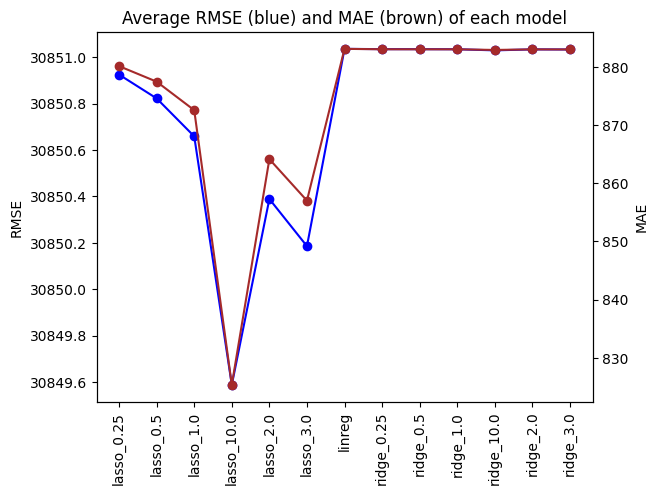

In [21]:
fig,ax=plt.subplots()
axtwin = ax.twinx()
dfmetrics_mean["rmse"].plot(ax=ax, marker="o", color="blue")
dfmetrics_mean["mae"].plot(ax=axtwin, marker="o", color="brown")
ax.set_xticks(list(range(13)))
ax.set_xticklabels(dfmetrics_mean["model"], rotation=90)
ax.set_ylabel("RMSE")
axtwin.set_ylabel("MAE")
ax.set_title("Average RMSE (blue) and MAE (brown) of each model");

**Die Grafik zeigt, dass Lasso mit $\alpha = 10.0$ am besten abschneidet.** Dies ist der höchste betrachtete Wert von $\alpha$, den ich genommen habe. Das deutet darauf hin, dass wir sogar noch höhere Werte von $\alpha$ ausprobieren könnten, um eine bessere Leistung zu erzielen. Allerdings variieren die Metriken nur in einem sehr engen Bereich, und die Verbesserung durch Cross-Validation ist nicht besonders erheblich.

# Welche Variablen sind relevant?

Um zu bestimmen, welche Variablen relevant sind, werde ich hier einen **Ablation-Test** durchführen:

* Ich werde Lasso($\alpha$=10) auf dem gesamten Datensatz trainieren.
* Anschließend werde ich auf dem gesamten Datensatz Vorhersagen treffen und die Metriken auswerten.
* Dann werde ich nacheinander eine Variable (oder eine Variablengruppe) entfernen (Ablation), erneut Vorhersagen treffen und sehen, wie sich die Metriken verändern.
* Abschließend werde ich die Differenz von RMSE und MAE mit und ohne Ablation für jede Variable plotten.
* Die Variable, bei der die Differenz am größten ist, ist die wichtigste Variable, gefolgt von den anderen Variablen.

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
regmod = Lasso(alpha=10.0)

X_train = df[features]
y_train = df["y"]
scaler = StandardScaler()
X_train[num_attribs] = scaler.fit_transform(X_train[num_attribs])

regmod.fit(X_train, y_train)

Lasso(alpha=10.0)

In [10]:
# parameters of trained model
pd.DataFrame({"feature":list(X_train.columns), "coeff":list(regmod.coef_)})

,feature,coeff
0,Exposure,-2.917352e+02
1,VehPower,3.245393e+01
2,VehAge,1.159726e+00
3,DrivAge,-4.874914e+02
4,BonusMalus,2.174472e+02
5,Density,-3.466553e+01
6,Area_A,-1.765486e-01
7,Area_B,7.804290e+01
8,Area_C,-2.821875e+01
9,Area_D,0.000000e+00


* **<font color=blue>Es ist interessant zu beobachten, dass der Koeffizient für `DrivAge` negativ ist. Das bedeutet, dass jüngere Fahrer mit höherer Wahrscheinlichkeit Schäden verursachen. Dies wurde auch in der Grafik der durchschnittlichen Schadensansprüche in Abhängigkeit vom `DrivAge` deutlich.</font>**

In [11]:
from sklearn.inspection import permutation_importance

results = permutation_importance(regmod, X_train, y_train, scoring='neg_mean_squared_error')
print(results.importances_mean)


[1.74845928e+05 2.49099146e+03 5.52885383e+01 4.91379125e+05
 9.11262038e+04 2.64616468e+03 6.48853688e+00 2.50155933e+03
 2.74210470e+02 0.00000000e+00 1.78913397e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34333828e+04
 0.00000000e+00 0.00000000e+00 3.45008819e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.75426406e+03
 0.00000000e+00 3.88012787e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.40640872e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.58137661e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.93175604e+05
 0.00000000e+00 0.00000000e+00]


In [16]:
df_perm_imp = pd.DataFrame({"feature":list(X_train.columns),"score":list(results.importances_mean)})
df_perm_imp.sort_values(by="score")

,feature,score
24,VehGas_Regular,0.000000
26,Region_R21,0.000000
27,Region_R22,0.000000
28,Region_R23,0.000000
30,Region_R25,0.000000
31,Region_R26,0.000000
32,Region_R31,0.000000
33,Region_R41,0.000000
34,Region_R42,0.000000
35,Region_R43,0.000000


In [54]:
# predict on full data
y_pred = regmod.predict(X_train)
rmse_full = np.sqrt(mean_squared_error(y_train, y_pred))
mae_full = mean_absolute_error(y_train, y_pred)

In [55]:
print("RMSE with all features: {}".format(rmse_full))
print("MAE with all features: {}".format(mae_full))

RMSE with all features: 37067.236154225735
MAE with all features: 822.6310917803153


In [56]:
brands = ['VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
          'VehBrand_B13','VehBrand_B14', 'VehBrand_B2',  'VehBrand_B3',
          'VehBrand_B4', 'VehBrand_B5' , 'VehBrand_B6']

regions = ['Region_R11', 'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25',
           'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
           'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74', 'Region_R82',
           'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94']

areas = ["Area_A", "Area_B", "Area_C", "Area_D", "Area_E", "Area_F"]


features_to_ablate = [["Exposure"], 
                      ["VehPower"], 
                      ["VehAge", "VehAgeSq"],
                      ["DrivAge","DrivAgeSq"],
                      ["BonusMalus"],
                      ["Density", "DensitySq"],
                      areas,
                      brands,
                      ['VehGas_Diesel', 'VehGas_Regular'],
                      regions]   
    
feature_names_ablated = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus",
                         "Density", "Area", "VehBrand", "VehGas", "Region"]   

In [57]:
rmse_vals_ablated = []
mae_vals_ablated = []
for fa in features_to_ablate:
    X_train = df[features]
    y_train = df["y"]
    # ablate the data
    for f in fa:
        X_train[f] = 0.0
    # predict on ablated data
    y_pred = regmod.predict(X_train)
    rmse_ablated = np.sqrt(mean_squared_error(y_train, y_pred))
    mae_ablated = mean_absolute_error(y_train, y_pred)
    rmse_vals_ablated.append(rmse_ablated)
    mae_vals_ablated.append(mae_ablated)

In [74]:
df_ablated_metrics = pd.DataFrame({"ablated_feature":feature_names_ablated,
                          "rmse_ablated":rmse_vals_ablated,
                          "mae_ablated":mae_vals_ablated})
df_ablated_metrics["rmse_full"] = rmse_full
df_ablated_metrics["mae_full"] = mae_full
df_ablated_metrics["rmse_diff"] = df_ablated_metrics["rmse_ablated"] - df_ablated_metrics["rmse_full"]
df_ablated_metrics["mae_diff"] = df_ablated_metrics["mae_ablated"] - df_ablated_metrics["mae_full"]
df_ablated_metrics.sort_values(by="rmse_diff")

,ablated_feature,rmse_ablated,mae_ablated,rmse_full,mae_full,rmse_diff,mae_diff
3,DrivAge,1.498429e+05,57833.989335,37067.236154,822.631092,1.127757e+05,57011.358244
4,BonusMalus,1.109220e+06,923371.365149,37067.236154,822.631092,1.072152e+06,922548.734057
1,VehPower,1.119018e+06,935777.082642,37067.236154,822.631092,1.081951e+06,934954.451551
9,Region,1.119150e+06,935931.194737,37067.236154,822.631092,1.082083e+06,935108.563645
7,VehBrand,1.119163e+06,935947.464738,37067.236154,822.631092,1.082096e+06,935124.833647
6,Area,1.119182e+06,935967.881126,37067.236154,822.631092,1.082115e+06,935145.250034
2,VehAge,1.119186e+06,935973.307086,37067.236154,822.631092,1.082118e+06,935150.675994
8,VehGas,1.119220e+06,936015.227949,37067.236154,822.631092,1.082152e+06,935192.596857
0,Exposure,1.119331e+06,936132.821329,37067.236154,822.631092,1.082264e+06,935310.190238
5,Density,1.162889e+06,991606.958302,37067.236154,822.631092,1.125822e+06,990784.327210


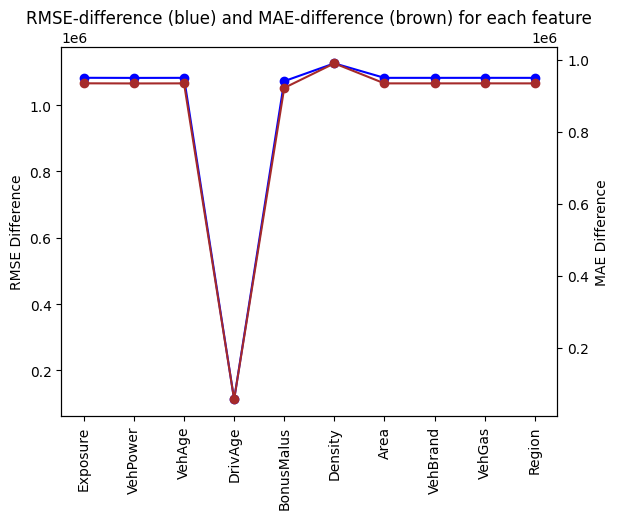

In [73]:
fig,ax=plt.subplots()
axtwin = ax.twinx()
df_ablated_metrics["rmse_diff"].plot(ax=ax, marker="o", color="blue")
df_ablated_metrics["mae_diff"].plot(ax=axtwin, marker="o", color="brown")
ax.set_xticks(list(range(10)))
ax.set_xticklabels(df_ablated_metrics["ablated_feature"], rotation=90)
ax.set_ylabel("RMSE Difference")
axtwin.set_ylabel("MAE Difference");
ax.set_title("RMSE-difference (blue) and MAE-difference (brown) for each feature");

* **<font color=blue>Die obige Grafik zeigt, dass `DrivAge` die wichtigste Variable ist, da das Modell ohne sie am schlechtesten abschneidet.</font>**
* **<font color=blue>Leider ist es schwierig, Schlussfolgerungen über die anderen Variablen zu ziehen, da sich die Differenz in den Metriken kaum verändert.</font>**

## Weitere Überlegungen und Optimierungspotenzial

* Hier wurden die kategorialen Variablen one-hot-encodiert, aber ihre Wechselwirkungen mit anderen Variablen wurden nicht berücksichtigt. Es ist möglich, dass bestimmte numerische Merkmale nur innerhalb einer bestimmten Kategorie linear mit der Zielvariablen skalieren. Solche Fälle können modelliert werden, indem ein Produktterm zwischen der numerischen Variable und der kategorialen Variable hinzugefügt wird.

* In der Literatur finden sich Poisson- und Tweedie-Verteilungen (siehe [hier](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#id2)). Ein weiterer interessanter Schritt wäre, Generalized Linear Models (GLMs) mit der Poisson- oder Tweedie-Verteilung zu trainieren und zu untersuchen, wie gut sie performen. Das GLM mit einem Tweedie-Regressor ist in scikit-learn verfügbar (siehe [hier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html)).

* Weitere Kandidatenmodelle sind Boosting-basierte Modelle (siehe [hier](https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py), [hier](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) und [hier](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)) sowie künstliche neuronale Netze (ANN). Es ist möglich, dass diese Modelle deutlich genauer sind, aber nicht leicht interpretierbar.
